# Link Deletion
example notebook demonstrating link deletion

In [1]:
import os

In [2]:
os.environ["DGLBACKEND"] = "pytorch"

In [3]:
import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Import toy graph data

In [4]:
ds = dgl.data.CSVDataset('./DGL_playground/toy_dataset/')

Done loading data from cached files.


In [5]:
g = ds[0]

In [6]:
g.edata['w'] = torch.rand(g.num_edges(),1)

In [7]:
g.edges(form='all')

(tensor([0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]),
 tensor([1, 2, 3, 0, 2, 0, 1, 0, 4, 5, 3, 5, 3, 4, 7, 8, 6, 8, 6, 7]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]))

### visualize graph 

In [8]:
#Function to quickly visualize a graph. Visualization options can be passed as a dictionary
def plot_net(net,options = None):
    netG = dgl.to_networkx(net)
    plt.figure(figsize=[15,7])
    if options != None:
        nx.draw(netG,**options)
    else:
        nx.draw(netG)

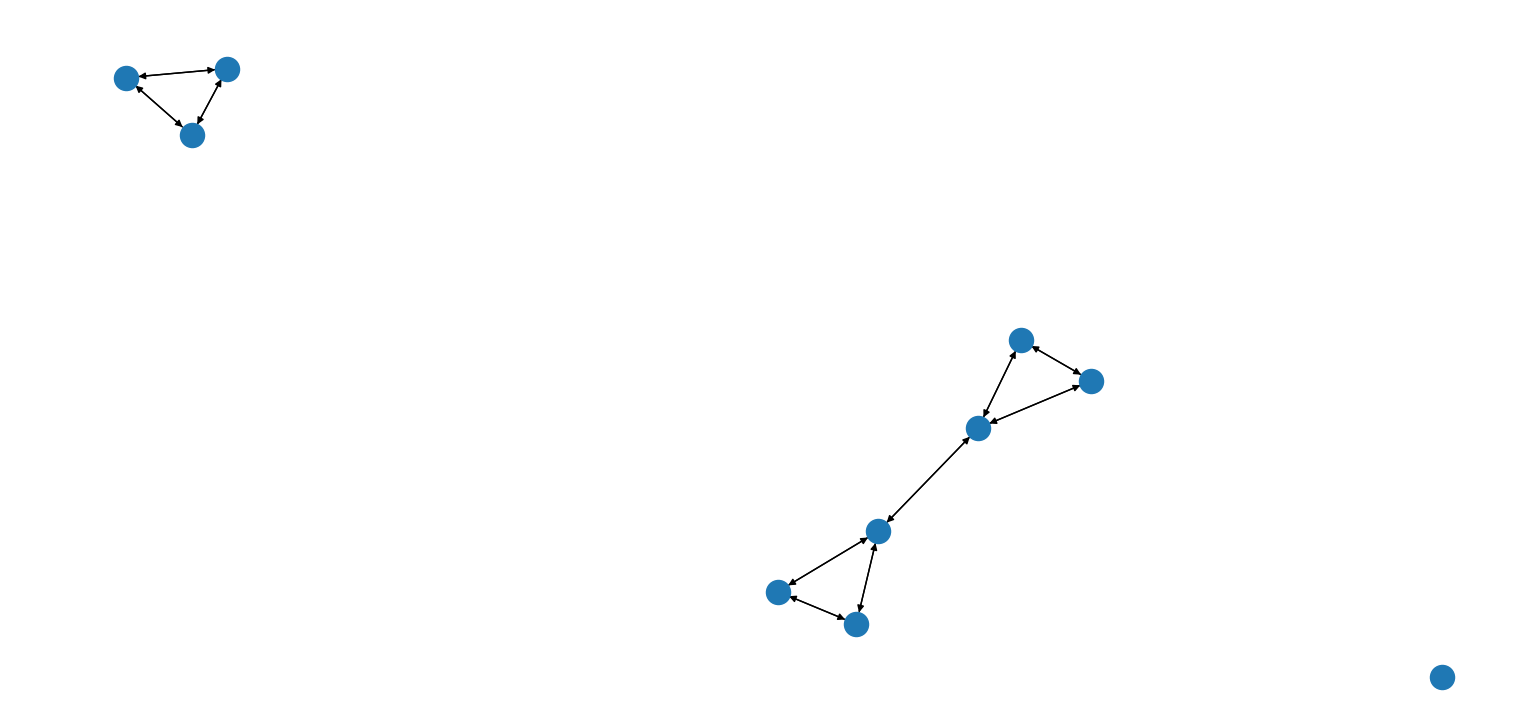

In [9]:
plot_net(g)

## Select (bidirectional) edges for deletion using adjacency matrix
Since all edges in the considered graph are bidirectional the adjcency matrix is symmetrical. Accordingly, edges for deletion can be selected on the upper (or lower) tringular matrix of the adjacency matrix with the row and column coordinates `i,j` indicating `src` and `dst` nodes.

Once links for deletion have been selected the reverse direction cn be added by adding the transpose.

Edges are identified for deletion by comparison of a uniformly distriibuuted random number with a preset deletion probability

Here we make use of the fact that the values on the non-zero elements of the adjacency matrix default to `0`. This could also make use of a prroperty (as retrieved in the `adj_mat_with_edge_prop()`)

In [10]:
adj = g.adj()

In [11]:
adj

SparseMatrix(indices=tensor([[0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8],
                             [1, 2, 3, 0, 2, 0, 1, 0, 4, 5, 3, 5, 3, 4, 7, 8, 6, 8, 6, 7]]),
             values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                            1., 1.]),
             shape=(10, 10), nnz=20)

A dense presentation of a sparse matrix can (in DGL) be obtained as below. This nly makes sense in the case of smallish toy graphs 

In [12]:
adj.to_dense()

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
#apply mask to a sparse matrix and return an appropriately masked sparse matrix
def sparse_matrix_apply_mask(om, mask):
    """
    om: the original sparse matrix (dgl.sparse.SparseMatrix)
    mask: the mask to be applied (tensor)
    """
    return dgl.sparse.from_coo(om.row[mask],om.col[mask],om.val[mask],shape=om.shape)

In [14]:
#select the upper triangular matrix from a sparse matrix
def sparse_upper_triangular(spm):
    """
    
    param: spm: the sparse matrix (dgl.sparse.SparseMatrix)
    return: dgl.sparse.SparseMatrix
    """
    mask = spm.row <= spm.col
    return sparse_matrix_apply_mask(spm,mask)

In [15]:
#create a symmetrical matrix based on an input upper triangular matrix. Note, this works because the diagonal is zero as we have no self-loops  
def symmetrical_from_upper_triangular(triu):
    """
    param : triu upper triangular matrix
    """
    return triu + triu.T

Set the deletion probability threshold. All edges with probabilities BELOW this value will be marked for deletion

In [16]:
deletion_probability = 0.3

Get upper triangular matrix of adjacency matrix

In [17]:
triu_adj = sparse_upper_triangular(adj)

Define random probability field for all non-zero elements of upper triangulr adjacency matrix

In [18]:
selection_values = triu_adj.val*torch.rand(triu_adj.val.size()[0])

In [19]:
selection_values

tensor([0.4571, 0.1432, 0.5847, 0.2158, 0.5520, 0.2319, 0.5418, 0.5957, 0.7769,
        0.1256])

Create selection mask

In [20]:
del_links = selection_values < deletion_probability

Apply mask to upper triangular adjacency matrix, resultiing in a matrix containing only edges to be deleted

In [21]:
triu_adj_del = sparse_matrix_apply_mask(triu_adj,del_links)

Symmetrize matrix of links to be delected to also delete reverse edge

In [22]:
sym_triu_adj_del = symmetrical_from_upper_triangular(triu_adj_del)


### Obtaining edge ids from row and column numbers 

The rows of the matrix correspond to the node ids of the src nodes for the links to be deleted, while the columns correspond to those of the dst nodes. Use the builtin fucntio to retrieve the edge ids for tuples of src and dst node ids

In [23]:
deledge_ids = g.edge_ids(sym_triu_adj_del.row,sym_triu_adj_del.col)  

Use builtin to remove a list of edges, idenified by edge id, from the graph

In [24]:
g.remove_edges(deledge_ids)

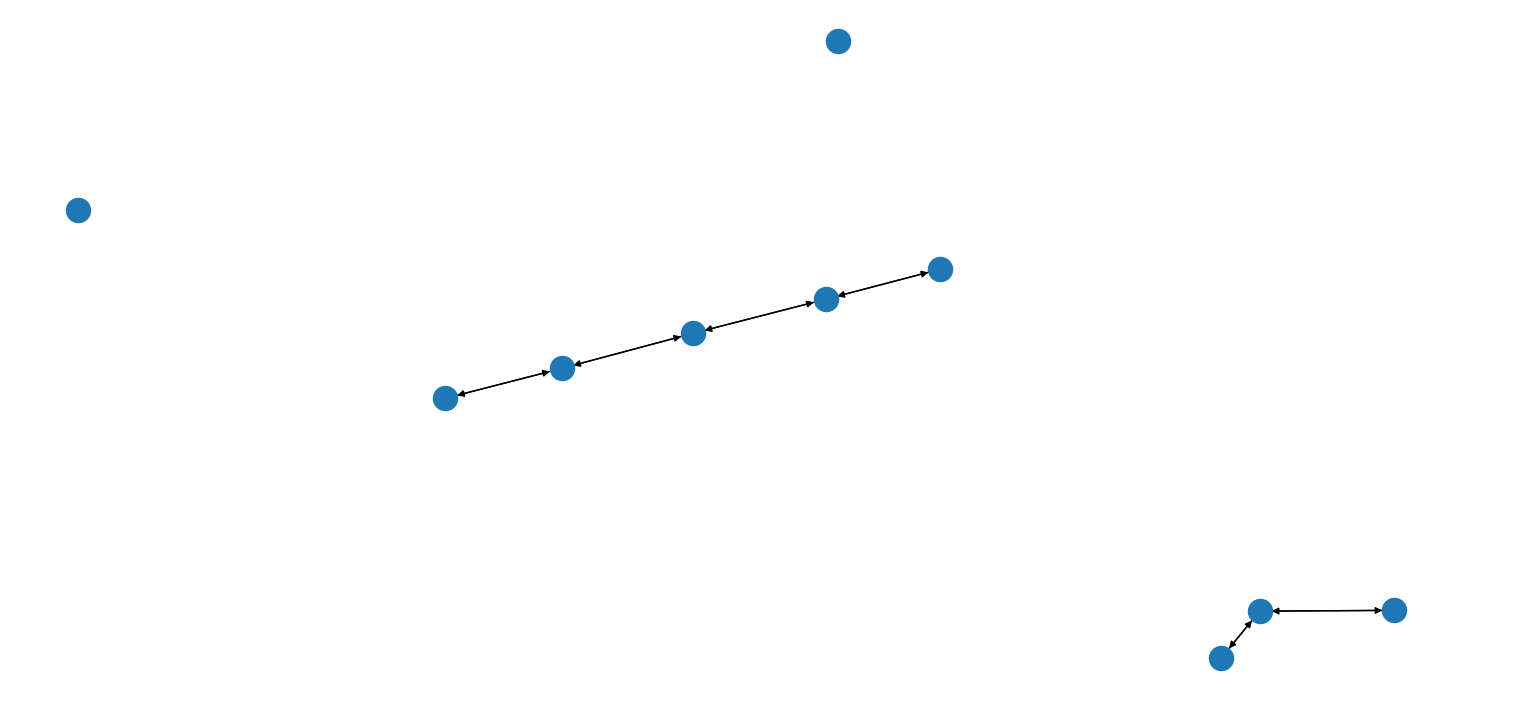

In [25]:
plot_net(g)